Checking for NaN values:
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustSpeed    10263
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday            0
RainTomorrow         0
dtype: int64
Checking for infinite values:
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64


/var/folders/0w/4d7v1n1s7wd7n4dnv5f69jbh0000gn/T/ipykernel_30929/2268157819.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_df.fillna(numeric_df.mean(), inplace=True)  # Filling NaNs with the mean of each column
/var/folders/0w/4d7v1n1s7wd7n4dnv5f69jbh0000gn/T/ipykernel_30929/2268157819.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_df.replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/0w/4d7v1n1s7wd7n4dnv5f69jbh0000gn/T/ipykernel_30929/2268157819.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation:

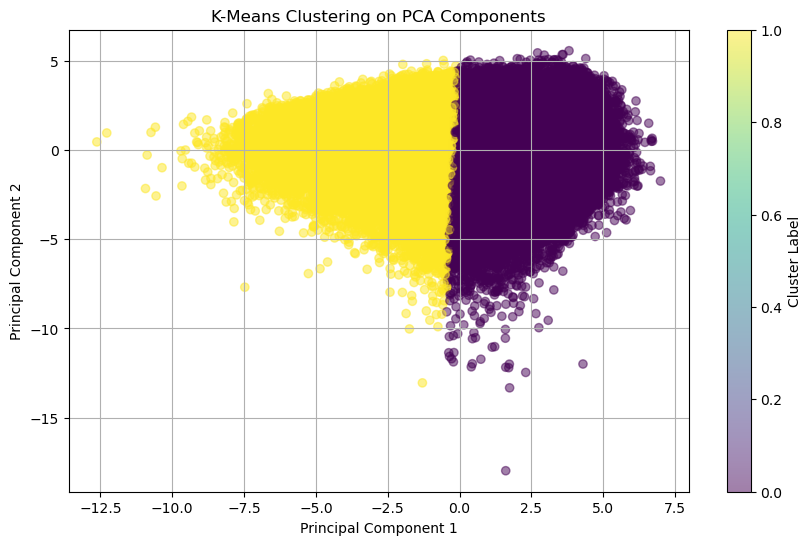

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Step 1: Load and preprocess the dataset
data = pd.read_csv('/Users/vanshpahwa/Downloads/weatherAus.csv')
df = pd.DataFrame(data)

# Encode categorical variables
label_encoder = LabelEncoder()
df['RainToday'] = label_encoder.fit_transform(df['RainToday'])
df['RainTomorrow'] = label_encoder.fit_transform(df['RainTomorrow'])

# Here, we will use all numerical features for PCA
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_df = df[numeric_features]
# Check for NaN and infinite values
print("Checking for NaN values:")
print(numeric_df.isna().sum())

print("Checking for infinite values:")
print(np.isinf(numeric_df).sum())

# Handle NaN values (you can choose to drop or fill)
numeric_df.fillna(numeric_df.mean(), inplace=True)  # Filling NaNs with the mean of each column

# Handle infinite values by replacing them with NaN and then filling
numeric_df.replace([np.inf, -np.inf], np.nan, inplace=True)
numeric_df.fillna(numeric_df.mean(), inplace=True)  # Filling NaNs again after replacing infs


# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)

# ----- PCA IMPLEMENTATION -----
# Compute covariance matrix
covariance_matrix = np.cov(scaled_data.T)  # Use .T because rows = samples, columns = features

# Eigen decomposition
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

# Sort eigenvalues and eigenvectors
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

# Select top 2 principal components
top_2_components = sorted_eigenvectors[:, :2]

# Project data onto PCA space
pca_result = scaled_data.dot(top_2_components)
pca_df = pd.DataFrame(pca_result, columns=['Principal Component 1', 'Principal Component 2'])
# -----------------------------------------

# Step 3: Implement K-Means (now using PCA-transformed data)
class KMeans:
    def __init__(self, n_clusters=2, max_iters=100):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.centroids = None

    def fit(self, X):
        # Initialize centroids randomly
        random_indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        self.centroids = X[random_indices]

        for _ in range(self.max_iters):
            # Assign clusters
            labels = self._assign_clusters(X)

            # Update centroids
            new_centroids = self._calculate_centroids(X, labels)

            # Check convergence
            if np.allclose(self.centroids, new_centroids):
                break

            self.centroids = new_centroids

        return labels

    def _assign_clusters(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

    def _calculate_centroids(self, X, labels):
        return np.array([X[labels == i].mean(axis=0) for i in range(self.n_clusters)])

# Step 4: Run K-Means on PCA-transformed data
kmeans = KMeans(n_clusters=2)
clusters = kmeans.fit(pca_result)

# Step 5: Visualize clusters using PCA components
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['Principal Component 1'], pca_df['Principal Component 2'], c=clusters, cmap='viridis', alpha=0.5)
plt.title('K-Means Clustering on PCA Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.grid()
plt.show()